# CSE688: Practical and Application of Machine Learning - Spring 2021
## Assignment 5-1
### Authors

- B073040018 朱劭璿
- B072010029 陳居廷

1. In the Gridworld, the cells of the grid corresponding to the states of the environment. At each cell, four actions are possible, **north**, **south**, **east** and **west**, which deterministaically cause the agent to move one cell in the respective direction on the grid. Actions that would take the agent off the grid leave its location unchanged, but also result in a reward of -1. Other actions result in a reward of 0, except those that move the agent out of the special states **A** and **B**. From state **A**, all four actions yield a reward of +10 an take the agent to **A'**. From state B, all action yield a reward of +5 and take the agent to **B'**.

<img src="../assets/images/env.png" alt="env.png" width="20%">

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 24})

## Some helper function

In [2]:
def draw_grid(ax, arr):
    tb = matplotlib.table.Table(ax, bbox=[0, 0, 1, 1])
    
    nrows, ncols = arr.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    for (i,j), val in np.ndenumerate(arr):
        tb.add_cell(i, j, width, height, text=val, loc='center')
        
    return tb

In [3]:
def take_action(cur_state, action):
    '''
    arguments:
        cur_state: np.array
        action:    np.array
        
    return: tuple(
        nxt_state: np.array
        reward:    float
    )
    '''
    # special states
    if (cur_state == A_state_g).all():
        return A_prime_state_g, A_reward_g
    if (cur_state == B_state_g).all():
        return B_prime_state_g, B_reward_g
    
    # boundry states
    nxt_state = cur_state+action
    if (nxt_state <  np.array([0, 0])).any() or \
       (nxt_state >= np.array([world_size_g, world_size_g])).any():
        return cur_state, -1.
    
    # normal states
    return nxt_state, 0.
    

## Recreate the environment in the decription

In [4]:
# Environment settings

world_size_g    = 5

A_state_g       = np.array([0, 1])
A_prime_state_g = np.array([4, 1])
B_state_g       = np.array([0, 3])
B_prime_state_g = np.array([2, 3])

A_reward_g      = 10.
B_reward_g      = 5.

gamma_g         = 0.9 # γ, discount factor

# actions: nesw
actions_g = np.array([
    [-1,  0],
    [ 0,  1],
    [ 1,  0],
    [ 0, -1]
])

policy_g = 1/actions_g.shape[0] # all the actions have uniform probability

bellman_equation_error_g = 1e-4

The world & Initial state value table


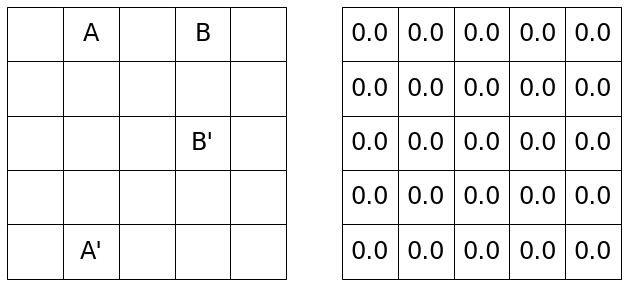

In [5]:
example_world = np.empty((world_size_g, world_size_g), dtype=object)
example_world[tuple(A_state_g)]       = 'A'
example_world[tuple(A_prime_state_g)] = 'A\''
example_world[tuple(B_state_g)]       = 'B'
example_world[tuple(B_prime_state_g)] = 'B\''

state_value_table = np.zeros((world_size_g, world_size_g))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 5))
print('The world & Initial state value table')
ax0.set_axis_off()
_ = ax0.add_table(draw_grid(ax0, example_world))
ax1.set_axis_off()
_ = ax1.add_table(draw_grid(ax1, state_value_table))

## With the policy of uniform probability

In [6]:
def solve_bellman_equation(v):
    '''
    arguments:
        v: np.array, prior state value table
    return:
        new_v: np,.rray, fulfilled state value table
    '''
    states = np.array(np.meshgrid(range(world_size_g), range(world_size_g))).T.reshape(-1,2)
    while True:
        new_v = np.zeros(v.shape)
        # iterate throught all the states
        for state in states:
            # iterate through all the actions
            for action in actions_g:
                nxt_state, reward = take_action(state, action)
                # bellman equation
                new_v[tuple(state)] += policy_g * (reward + gamma_g * v[tuple(nxt_state)])
                
        if np.sum(np.abs(v - new_v)) < bellman_equation_error_g:
            return np.round(new_v, decimals=1)
        v = new_v
                

Fulfilled state value table


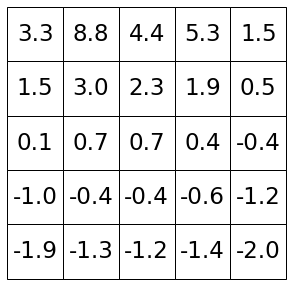

In [7]:
state_value_table = solve_bellman_equation(state_value_table)
fig, ax = plt.subplots(figsize=(5, 5))
print('Fulfilled state value table')
ax.set_axis_off()
_ = ax.add_table(draw_grid(ax, state_value_table))

## With greedy policy

In [8]:
def Q_learning(v):
    '''
    arguments:
        v: np.array, prior state value table
    return:
        new_v: np.array, fulfilled state value table
        pi   : np.array, π, policy table, "1111" means "nesw", "1101" means "new"
    '''
    states = np.array(np.meshgrid(range(world_size_g), range(world_size_g))).T.reshape(-1,2)
    pi     = np.empty(v.shape, dtype=object)
    while True:
        new_v = np.zeros(v.shape)
        # iterate throught all the states
        for state in states:
            # iterate through all the actions
            v_list = []
            for action in actions_g:
                nxt_state, reward = take_action(state, action)
                # bellman equation
                v_list.append(reward + gamma_g * v[tuple(nxt_state)])
                
            # take the action with biggest v, greedy!
            maxes = np.argwhere(v_list == np.amax(v_list)).T[0]
            # set policy to the actions which generate the biggest v
            pi[tuple(state)] = ''.join([
                '1' if idx in maxes else '0' for idx in range(actions_g.shape[0])
            ])
            new_v[tuple(state)] = v_list[maxes[0]]
                
        if np.sum(np.abs(v - new_v)) < bellman_equation_error_g:
            return np.round(new_v, decimals=1), pi
        v = new_v

In [9]:
def policy_postprocess(policy):
    for idx in np.array(np.meshgrid(range(world_size_g), range(world_size_g))).T.reshape(-1,2):
        new_p = []
        p = policy[tuple(idx)]
        for action in 'NESW':
            bit = p[0]
            if len(p): # check if size of p > 0
                p = p[1:]
            if int(bit):
                new_p.append(action)
        policy[tuple(idx)] = ''.join(new_p)
    return policy

The optimal state value table & the optimal policy table by Q-Learning


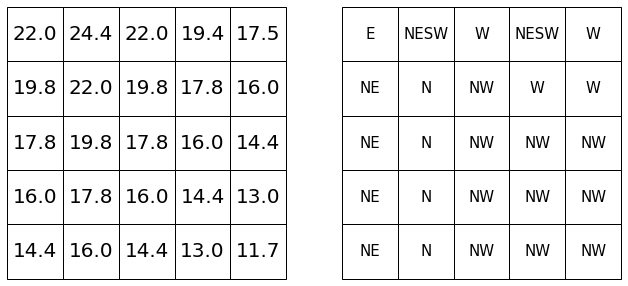

In [10]:
QL_state_value_table = np.zeros((world_size_g, world_size_g))
QL_state_value_table, QL_policy = Q_learning(QL_state_value_table)

QL_policy = policy_postprocess(QL_policy)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 5))
print('The optimal state value table & the optimal policy table by Q-Learning')
ax0.set_axis_off()
_ = ax0.add_table(draw_grid(ax0, QL_state_value_table))
ax1.set_axis_off()
_ = ax1.add_table(draw_grid(ax1, QL_policy))